In [61]:
import elevation_grid as eg
import sys
import geopandas as gd
import descartes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

assert sys.version_info >= (3, 5)  # make sure we have Python 3.5+

from mpl_toolkits.basemap import Basemap
from numpy import array
from pyspark.sql import SparkSession, functions, types
from pyspark.sql.functions import lit,floor
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, SQLTransformer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import PipelineModel

spark = SparkSession.builder.appName('weather prediction').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

### Part 2 - Task a - To plot max temperature distribution and its comparison between 1977-1996 and 1977 till 2017

###### Creation of temperature distribution dataset between two time periods

In [62]:
# Defining global variable here.Input used is tmax-2. 
input = "tmax-2"

# Defining the schema for tmax datasets
def weather_schema():
    tmaxschema = types.StructType([
        types.StructField('station', types.StringType()),
        types.StructField('date', types.DateType()),
        types.StructField('latitude', types.FloatType()),
        types.StructField('longitude', types.FloatType()),
        types.StructField('elevation', types.FloatType()),
        types.StructField('tmax', types.FloatType()),
    ])
    return tmaxschema

# Calculate the difference in max temperature between two 50 year time periods ie. 1977-'96 and 1997 -2017
def temp_max(input):
    tmax_schema = weather_schema()
    #Spark read of data
    temp = spark.read.csv(input, schema=tmax_schema).cache()
    # Remove rows that do not have temperature 
    temp = temp.filter(temp["tmax"].isNotNull())
    
    #Prepare two dataframes that has maximum temperatures for 50 years 
    temp.createOrReplaceTempView("temp")
    stat20 = spark.sql("select station,latitude,longitude,avg(tmax) as tmax1 from temp where year(date) >= 1997 and year(date) <= 2017 group by station,latitude,longitude").cache()
    stat19 = spark.sql(
        "select station,latitude,longitude,avg(tmax) as tmax2 from temp where year(date) >= 1977 and year(date) <= 1996  group by station,latitude,longitude").cache()

    stat20.createOrReplaceTempView("stat20")
    stat19.createOrReplaceTempView("stat19")

    # Calculate the difference to understand the change in climate
    stats = spark.sql("select a.latitude,a.longitude,(a.tmax1 - b.tmax2) as tdiff from stat20 a join stat19 b on a.station = b.station "
                      "and a.latitude = b.latitude and a.longitude = b.longitude").cache()
    
    #Categorize the temperature difference into multiple classes
    stats.createOrReplaceTempView("stats")
    stats_f = spark.sql("select *,CASE WHEN tdiff >= 9 THEN '+9° & above' "
                        "WHEN tdiff >= 7 AND tdiff < 9 THEN '+7° - +8°' "
                        "WHEN tdiff >= 4 AND tdiff < 7 THEN '+4° - +6°' "
                        "WHEN tdiff >= 2 AND tdiff < 4 THEN '+2° - +3°' "
                        "WHEN tdiff >= 1 AND tdiff < 2 THEN '+1°' "
                        "WHEN tdiff >= 0 AND tdiff < 1 THEN '+0°' "
                        "WHEN tdiff >= -1 AND tdiff < 0 THEN '-1°' "
                        "WHEN tdiff >= -3 AND tdiff < -1 THEN '-2° to -3°' "
                        "WHEN tdiff >= -6 AND tdiff < -3 THEN '-4° to -6°' "
                        "WHEN tdiff >= -8 AND tdiff < -6 THEN '-7° to -8°' "
                        #"WHEN tdiff >= -9 AND tdiff < -7 THEN '-8° to -9°' "
                        "else '<= -9°' end as category "
                        "from stats ")
    #stats_f.show()
    return stats_f



#Function to prepare the temperature comparison dataset
stats_result = temp_max(input)
#Conversion of spark df to pandas
stat = stats_result.toPandas()

###### Visualization of results using scatter plots

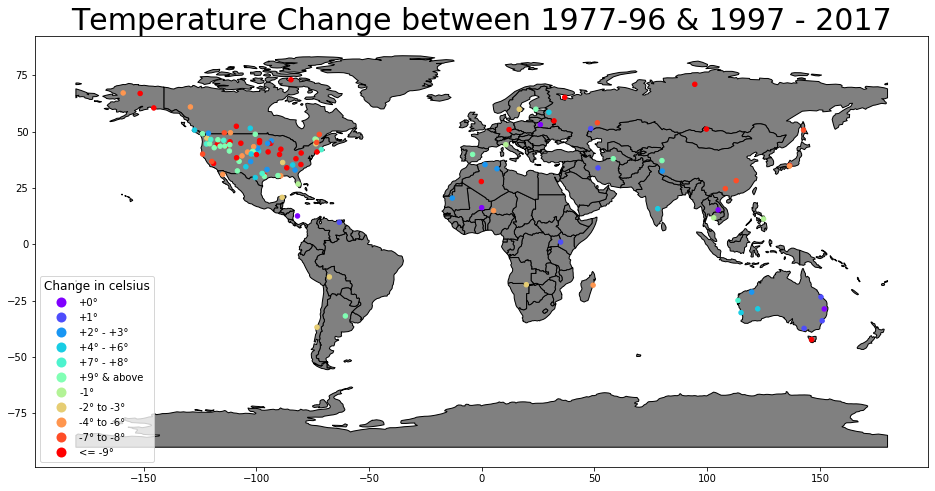

In [63]:
#Plotting of Data
def scatter_plot(stat):
    # Plot configurations
    figsize = (16, 10)
    plt.rc('legend', fontsize=10)
    plt.rcParams['legend.title_fontsize'] = 'large'
    
    #Geometry calculation of co-ordinates in dataset
    gdf1 = gd.GeoDataFrame(stat,geometry=gd.points_from_xy(stat.longitude, stat.latitude))
    # Obtaining the world map
    world = gd.read_file(gd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='gray',edgecolor='black',figsize=figsize)
    # Plotting the data
    gdf1.plot(ax=ax,column='category', categorical=True,legend=True,markersize=20,cmap='rainbow',figsize=figsize,legend_kwds={'loc': 'lower left'})
    # Title and legend setups
    leg = ax.get_legend()
    leg.set_title("Change in celsius")
    plt.title('Temperature Change between 1977-''96 & 1997 - 2017',fontsize=30)
    plt.show()
    
scatter_plot(stat)

Inferences:
The above visualization is an analysis of temperatures over past 40 years from 2017. A comparison has been done over two time periods i.e from 1977 to 1996 and from 1997 to 2017. Analyzing the average temperature change over two time frames provides us the above results. It can be inferred that majority of stations recorded a decrease in temperature with less than or equal to -9°. We can also note that weather observations are more in America compared to the rest of the world. Analyzing further on a continent basis, we can see that American continents has an equal distribution of positive and negative temperature changes. While Africa showeed a slight increase, countries in Europe highlights a decrease in temperature over the years. However Asian countries situated in equator showed an increase with Australia accompanying the same.Overall, in terms of temperature, we can infer that countries closer to polar region shows downward trend whereas countries in equator continue to be warmer.

### Part 2 - Prerequisites - Training the model for weather prediction with out yesterdays tmax

In [64]:
# Model is trained using tmax-2 dataset
dataset = "tmax-2"
model_file = "weather_model"

# Weather schema
def weather_schema():
    tmaxschema = types.StructType([
        types.StructField('station', types.StringType()),
        types.StructField('date', types.DateType()),
        types.StructField('latitude', types.DoubleType()),
        types.StructField('longitude', types.DoubleType()),
        types.StructField('elevation', types.DoubleType()),
        types.StructField('tmax', types.DoubleType()),
    ])
    return tmaxschema

# Model creation
def model_creator(input,model_file):
    tmax_schema = weather_schema()
    temp = spark.read.csv(input, schema=tmax_schema)
    # Training and test split
    train, validation = temp.randomSplit([0.75, 0.25],seed = 70)
    train = train.cache()
    validation = validation.cache()
    train.registerTempTable("train")
    # Query with out using yesterday max
    query = "SELECT latitude,longitude,elevation,DAYOFYEAR(date) as day,tmax as tmax FROM __THIS__"

    temp_sqltrans = SQLTransformer(statement= query)

    # Vector Assembler with out using yesterday max
    temp_assembler = VectorAssembler(inputCols=["latitude", "longitude", "elevation", "day"],outputCol="features")

    # Fitting Models
    regressor = GBTRegressor(featuresCol="features", labelCol='tmax', predictionCol='prediction')
   
    #Model evaluation
    evaluator = RegressionEvaluator(labelCol="tmax", predictionCol="prediction", metricName="rmse")

    temp_pipeline = Pipeline(stages=[temp_sqltrans, temp_assembler, regressor])
    tmax_model = temp_pipeline.fit(train)
    tmax_prediction = tmax_model.transform(validation)

    #RMSE and R2 score calculation
    rmse_score = evaluator.evaluate(tmax_prediction)

    evaluator_r2 = RegressionEvaluator(labelCol="tmax", predictionCol="prediction", metricName="r2")
    r2_score = evaluator_r2.evaluate(tmax_prediction)

    print('Validation  RMSE score for TMAX model: %g' % (rmse_score,))
    print('Validation  R2 score for TMAX model: %g' % (r2_score,))

    #Saving the model 
    tmax_model.write().overwrite().save(model_file)

#Calling the function to create the model
model_creator(dataset, model_file)

Validation  RMSE score for TMAX model: 5.97543
Validation  R2 score for TMAX model: 0.786028


### Task 2 - Part b1 - Evaluation of trained model at a grid of latitude, longitude positions around the globe spanning across oceans and continents, leading to a dense plot of temperatures. For this we would create a complete list of latitude and longitude across the globe using evaluate_grid utlity.

In [65]:
model_file = "weather_model"

#Function to perform prediction for global latitude and longitude
def global_pred():
    #Create a numpy array with all latitude and longitude and then obtain its elevation
    lats, lons = np.meshgrid(np.arange(-90,90,.5),np.arange(-180,180,.5))
    elevs = [eg.get_elevations(np.array([late,lone]).T) for late,lone in zip(lats,lons)]

    #Conversion of latitude and longitude into vector
    lat = [float(lt) for lt in array(lats).flat]
    lon = [float(ln) for ln in array(lons).flat]
    elev = [float(el) for el in array(elevs).flat]

    #Dataframe creation with all columns to be passed for prediction. Prediction is done for 2020-01-20
    df_global = spark.createDataFrame(zip(lat, lon, elev), schema=['latitude', 'longitude', 'elevation'])
    df_global = df_global.withColumn("station",lit('GLOB100'))
    date1 = datetime.datetime.strptime('2020-01-20', '%Y-%m-%d').date()
    df_global = df_global.withColumn("date",lit(date1))
    df_global = df_global.withColumn("tmax",lit(float(0.0)))
    df_global = df_global.select("station","date","latitude","longitude","elevation","tmax")

    #Prediction using saved model
    model = PipelineModel.load(model_file)
    predictions = model.transform(df_global)
    predictions = predictions.select("latitude","longitude","elevation","tmax","prediction")
    #predictions.show()
    return predictions

#Function call to global_pred
predictions = global_pred()
#Conversion of predicted results to pandas
result_df1 = predictions.toPandas()

###### Visualization using dense plots of predicted global co-ordinates

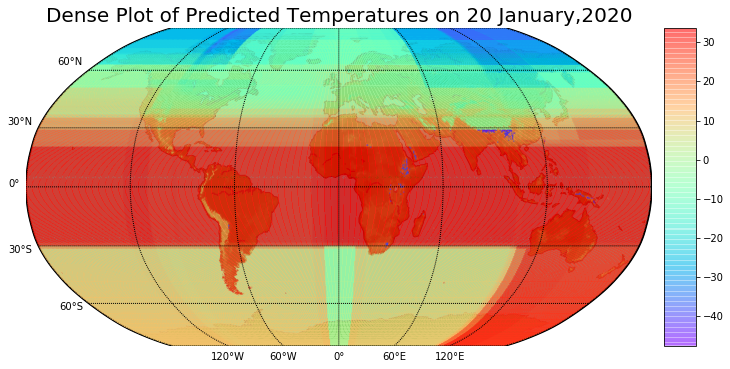

In [66]:
def denseplot(result_df1):
    plt.rcParams['figure.figsize'] = (12, 10)
    plt.title("Dense Plot of Predicted Temperatures on 20 January,2020",fontsize=20)
    
    #Creating basemap to make this plot
    mp = Basemap(projection='robin',lon_0=0,resolution='c')
    mp.drawcoastlines()
    mp.fillcontinents(color='green',lake_color='aqua')
    # draw parallels and meridians.
    mp.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0],fontsize=10)
    mp.drawmeridians(np.arange(0.,360.,60.),labels=[0,0,0,1],fontsize=10)
    # draw map buondaries
    mp.drawmapboundary(fill_color='aqua',linewidth=2)
    #Plotting of predictions across map
    lats, lons = np.meshgrid(np.arange(-90,90,.5),np.arange(-180,180,.5))
    z = result_df1["prediction"].values.reshape(lons.shape)
    mp.pcolormesh(lons,lats,z,cmap='rainbow',zorder=2, alpha=0.35,linewidth=1,latlon = True)
    cbar = mp.colorbar()
    plt.show()

denseplot(result_df1)

Inferences:
The predictions show that the regions towards equator shows higher temperature.The red colour dominance show 
that the temperature predicted is 20 degree and above.This infact matches to the general idea that the equatorial 
belt follows a hot weather.We can also note that regions situated in Europe and America shows a cooler weather 
ranging from 10 to -40 degree celsius. Some of the short comings this model has produced is that the weather 
in southern poles shows a warmer temperature between 10 and 20 degree celsius.
    

### Task 2 - Part b12 - Regression error of model predictions against test data

In [67]:
#Model and test data file name declarations
model_file = "weather_model"
test_data = "tmax-test"

#define the schema
tmaxschema = types.StructType([
    types.StructField('station', types.StringType()),
    types.StructField('date', types.DateType()),
    types.StructField('latitude', types.DoubleType()),
    types.StructField('longitude', types.DoubleType()),
    types.StructField('elevation', types.DoubleType()),
    types.StructField('tmax', types.DoubleType()),
])

def test_model(model_file, inputs):
    # get the data
    test_tmax = spark.read.csv(inputs, schema=tmaxschema)
    test_tmax.createOrReplaceTempView("test_tmax")
    test_tmax = spark.sql("select * from test_tmax where year(date) = 2015")
    test_tmax = test_tmax.filter(test_tmax["tmax"].isNotNull())

    # load the model
    model = PipelineModel.load(model_file)
    
    # use the model to make predictions
    test_output = model.transform(test_tmax)
    
    # Inclusion of regression error
    test_output = test_output.withColumn("R_Error",floor(test_output["prediction"] - test_output["tmax"]))
    
    # Below code groups those latitude and longitude and obtains average error. This avoids overplotting
    test_output.createOrReplaceTempView("test_out")
    test_output = spark.sql("select latitude,longitude,avg(R_Error) as R_Error from test_out group by latitude,longitude")
    
    # Categorizing regression for the easiness to plot
    test_output.createOrReplaceTempView("test")
    test_output = spark.sql("select *,CASE WHEN R_Error >= 9 THEN '+9° & above' "
                        "WHEN R_Error >= 7 AND R_Error < 9 THEN '+7° - +8°' "
                        "WHEN R_Error >= 4 AND R_Error < 7 THEN '+4° - +6°' "
                        "WHEN R_Error >= 2 AND R_Error < 4 THEN '+2° - +3°' "
                        "WHEN R_Error >= 1 AND R_Error < 2 THEN '+1°' "
                        "WHEN R_Error >= 0 AND R_Error < 1 THEN '+0°' "
                        "WHEN R_Error >= -1 AND R_Error < 0 THEN '-1°' "
                        "WHEN R_Error >= -3 AND R_Error < -1 THEN '-2° to -3°' "
                        "WHEN R_Error >= -6 AND R_Error < -3 THEN '-4° to -6°' "
                        "WHEN R_Error >= -8 AND R_Error < -6 THEN '-7° to -8°' "
                        #"WHEN tdiff >= -9 AND tdiff < -7 THEN '-8° to -9°' "
                        "else '<= -9°' end as category "
                        "from test ")
    return test_output

#Prediction function test_model
test_predictions = test_model(model_file, test_data)

#Conversion of spark df to pandas
t_pred = test_predictions.toPandas()

###### Visualize the results for test data

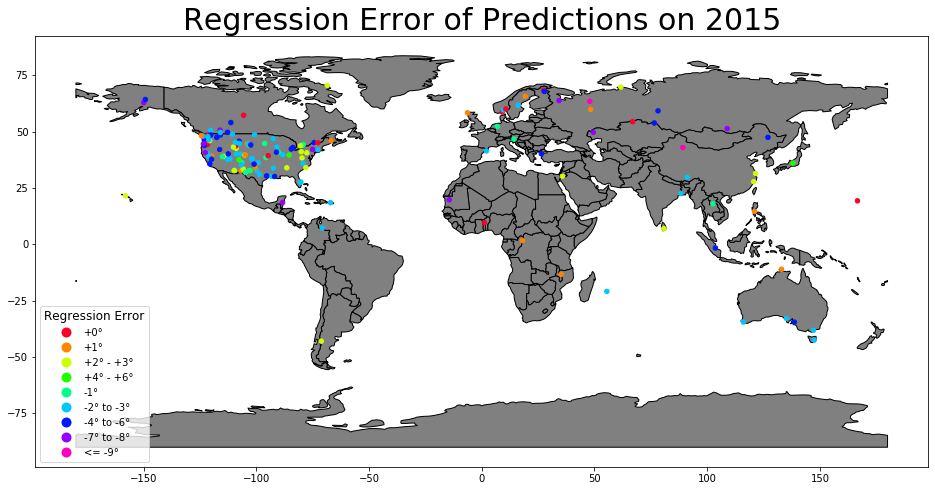

In [68]:
def scatter_plot_error(t_pred):
    #Plotting Configurations
    figsize = (16, 10)
    plt.rc('legend', fontsize=10)
    plt.rcParams['legend.title_fontsize'] = 'large'
    #Geometry calculation of co-ordinates in dataset
    gdf1 = gd.GeoDataFrame(t_pred,geometry=gd.points_from_xy(t_pred.longitude, t_pred.latitude))
    #Setting the world map
    world = gd.read_file(gd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='gray',edgecolor='black',figsize=figsize)
    #Plotting of data
    gdf1.plot(ax=ax,column='category', categorical=True,legend=True,markersize=20,cmap='gist_rainbow',figsize=figsize,legend_kwds={'loc': 'lower left'})
    # Legend and Title settings
    leg = ax.get_legend()
    leg.set_title("Regression Error")
    plt.title('Regression Error of Predictions on 2015',fontsize=30)
    plt.show()
    
scatter_plot_error(t_pred)

Inferences:
Regression plot provided above is obtained for the entire year of 2015 taken tmax-test dataset. Overall the average regression error is closer to the regression line +/- 3° with few stations showing a large difference. 